# Splines

> Spline models and samples

In [ ]:
#| default_exp model_helpers.spline_models

In [ ]:
#| hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt
from tueplots import bundles
from tueplots.constants.color import rgb
import warnings
import pandas as pd

In [ ]:
#| hide
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
#| export
import numpy as np
import pymc as pm
from patsy import dmatrix
import xarray as xr
from typing import TypeVar, List, Iterable

In [ ]:
#| hide
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [ ]:
#| export
_T = TypeVar("T")

In [ ]:
#| export
def spline_component(
    knots: int | List[_T], # Number of knots or interior knots to use
    index: Iterable[_T], # index
    degree: int = 3, # Knot degree defaults to cubic splines
):
    if isinstance(knots, int):
        steps = len(index)/(knots)
        knots_ = [index[int(i*steps)] for i in range(knots)]
        knots = knots_[1:-1]
    
    
    splines = dmatrix(
        "bs(x, knots=knots, degree=degree, include_intercept=False)-1", 
        {
            'x': index,
            'knots': knots,
            'degree': degree
        }
    )
    return np.asarray(splines)
    

:::{#exm-num-splines-def}
## If knots are an integer

In [ ]:
N_SPLINES = 9
INDEX = [i for i in range(156)]
splines = spline_component(
    N_SPLINES,
    INDEX
)

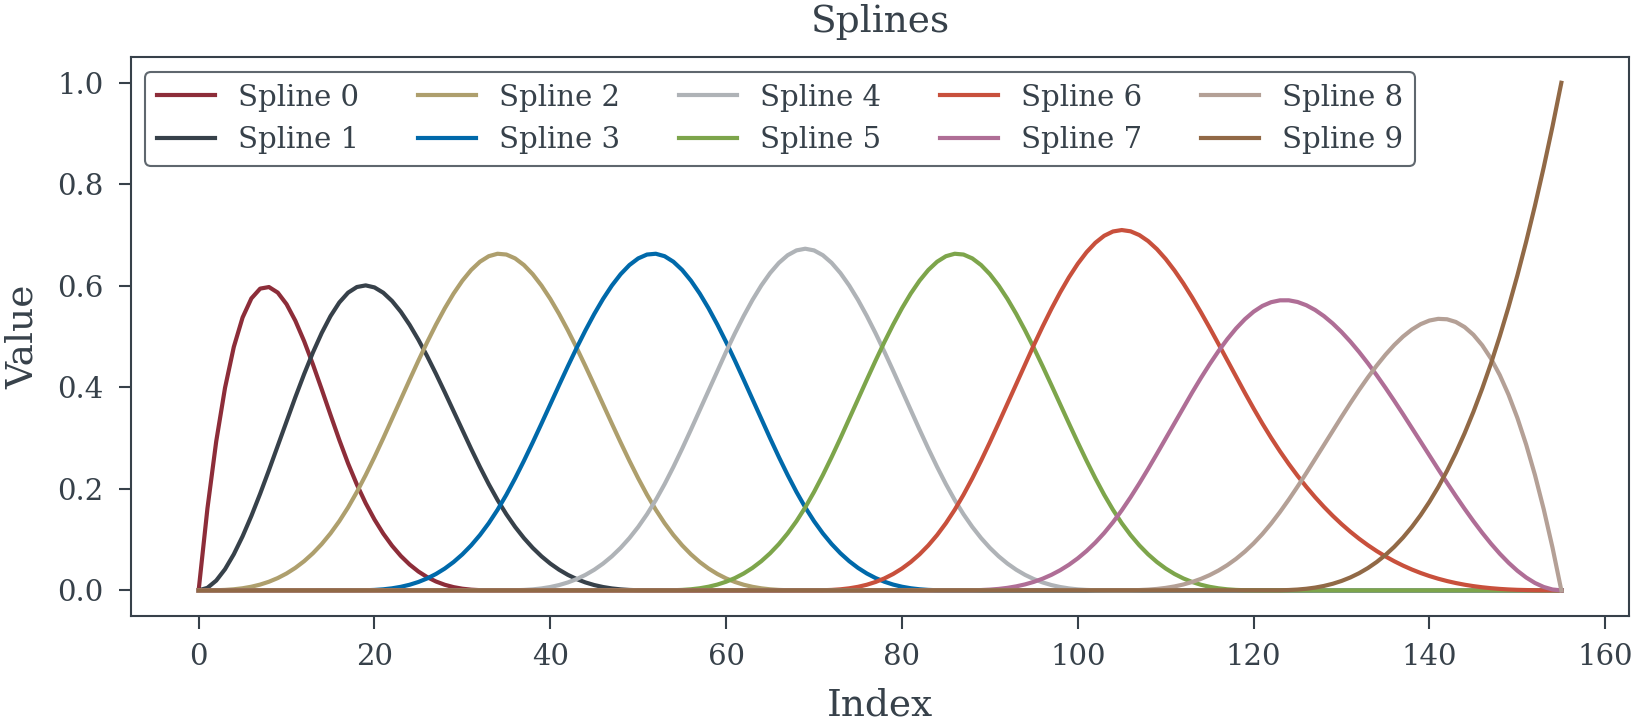

In [ ]:
#| echo: false
#| label: fig-nknots-splines
#| fig-cap: Representation of splines 
for i in range(splines.shape[1]):
    plt.plot(splines[:,i], label=f"Spline {i}")
plt.legend(ncols=5);
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Splines");

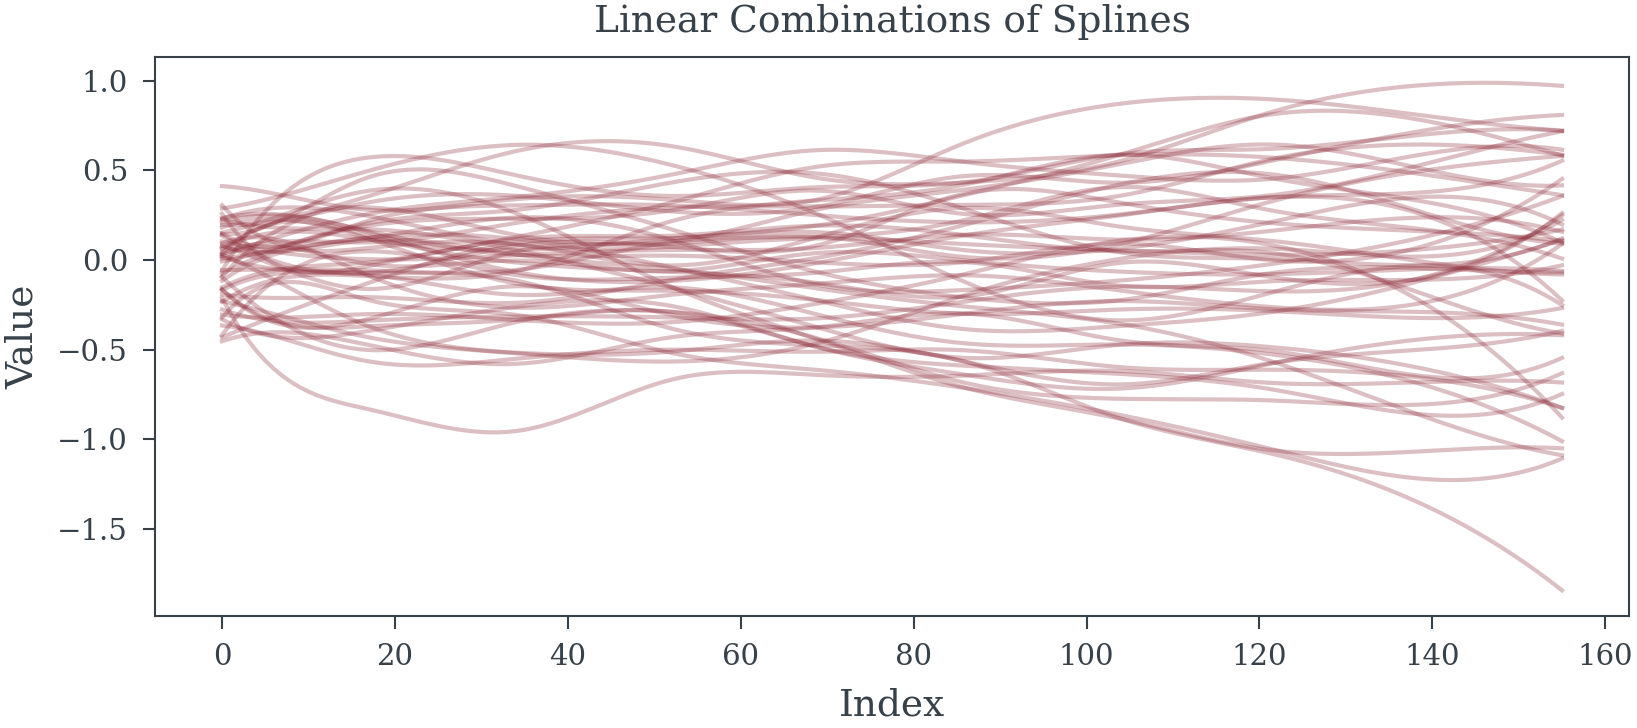

In [ ]:
#| echo: false
#| label: fig-sample-nknots-splines
#| fig-cap: Samples of linear combination of splines.
plt.plot((
    splines 
    @ (np.random.normal(
        0, 
        .2, 
        size=(splines.shape[1], 50))
        .cumsum(axis=0))
    ) + np.random.normal(0, .2, size=50),
    c='C0', 
    alpha=0.3)
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Linear Combinations of Splines");

:::

:::{#exm-knots-defined}
## Knots can be directly specified

In [ ]:
INDEX = pd.date_range('01/01/2021', periods=156, freq="W-MON")
KNOTS = [INDEX[10], INDEX[30], INDEX[60], INDEX[120]]
splines_date = spline_component(
    list(map(INDEX.get_loc, KNOTS)),
    np.arange(len(INDEX))
)

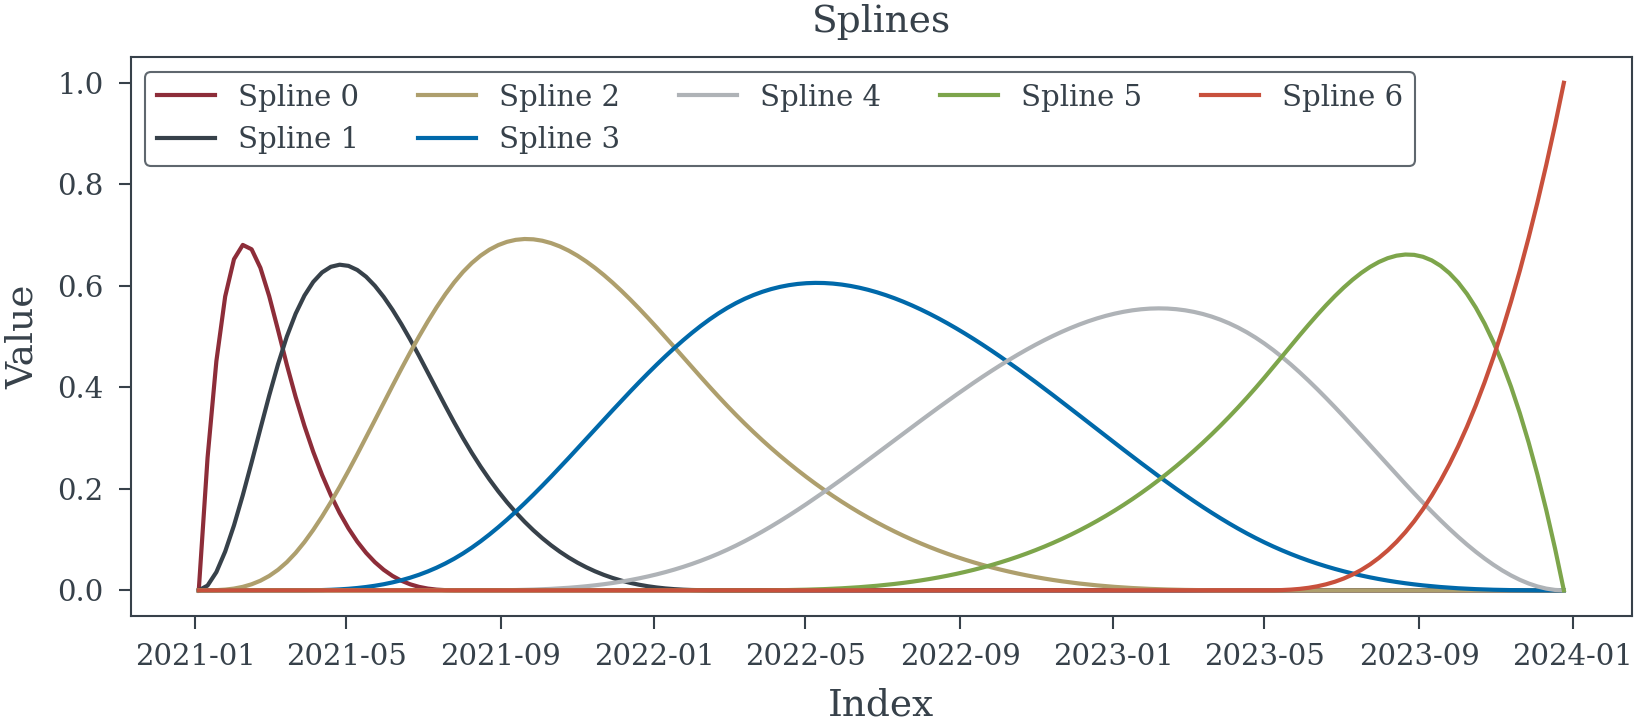

In [ ]:
#| echo: false
for i in range(splines_date.shape[1]):
    plt.plot(INDEX, splines_date[:,i], label=f"Spline {i}")
plt.legend(ncols=5);
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Splines");

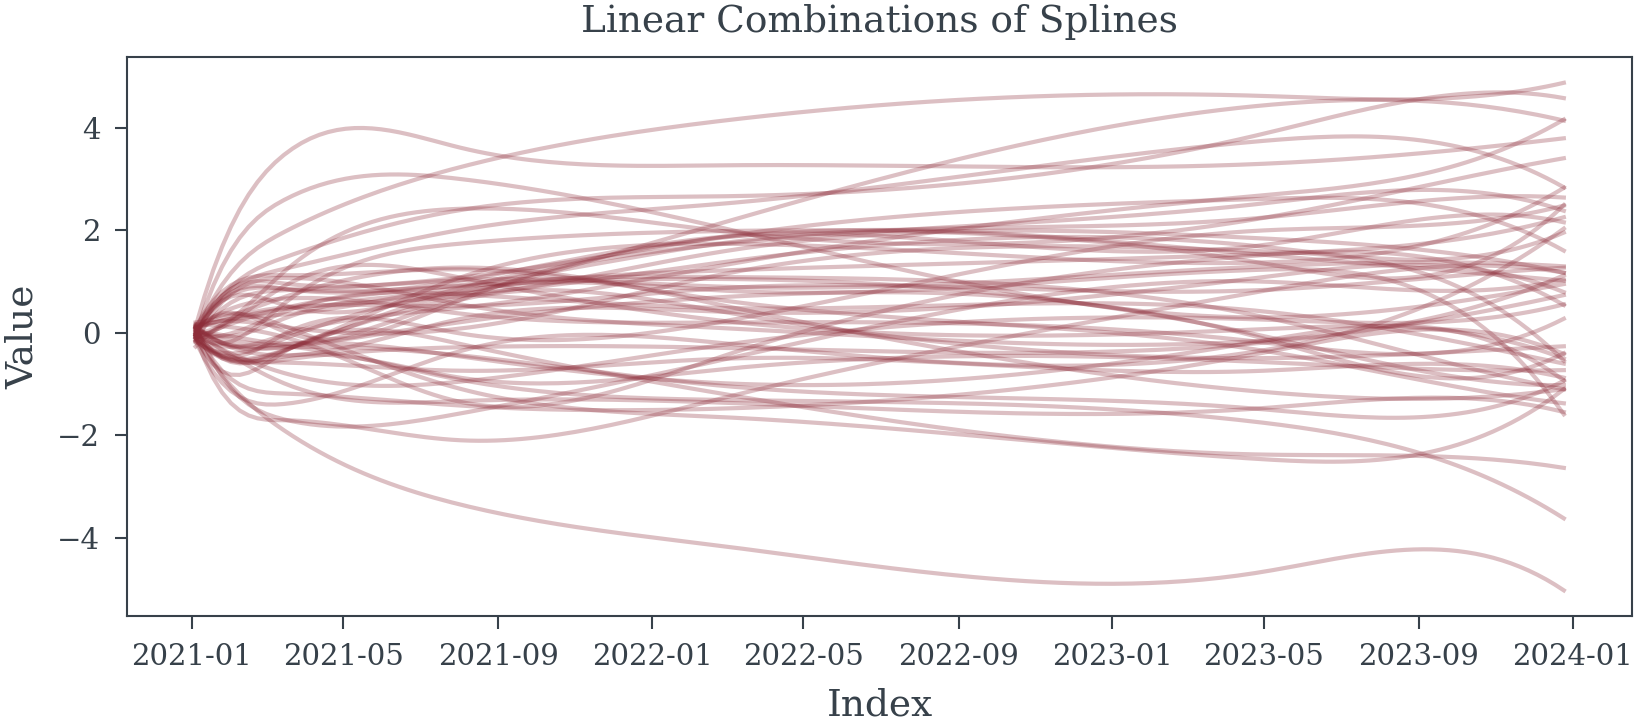

In [ ]:
#| echo: false
plt.plot(INDEX, (
    splines_date 
    @ (np.random.normal(
        0, 
        1, 
        size=(splines_date.shape[1], 50))
        .cumsum(axis=0) + np.random.normal(0, .1, size=(splines_date.shape[1], 50)))
    ) + np.random.normal(0, .1, size=50),
    c='C0', 
    alpha=0.3)
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Linear Combinations of Splines");

:::

::: {#exm-spline-regression-model}
## Spline Regression Model

In [ ]:
#| eval: false
INDEX = np.linspace(0, 1, 156)

spline_data = spline_component(19, INDEX, degree=3) # 19 Splines
fun_ = lambda x: np.sin(2*np.pi*5*x)/(20*(x-.5)) + (x-.5) * 2
fun = fun_(INDEX)# Complex Non-linear function to learn

y_obs = fun + np.random.normal(0, .1, size=spline_data.shape[0]) # Noisy observation process

tau_scale = 1.0
c_scale = 0.1
with pm.Model() as model:
    tau = pm.HalfCauchy('tau', tau_scale)
    lambdas = pm.HalfCauchy("lambdas", 1, shape=spline_data.shape[1])
    c = pm.HalfCauchy("c", beta=c_scale)

    sigma_coeff = pm.Deterministic("sigma_coeff", tau * lambdas / pm.math.sqrt(c**2 + (tau * lambdas)**2))
    betas_ = pm.Normal("betas_", 0, sigma_coeff)
    betas = pm.Deterministic("betas", pm.math.cumsum(betas_)) # Enforce Random Walk Process

    alpha = pm.Normal("alpha", 0, 1)

    spline_trend = pm.Deterministic("splines", spline_data@betas + alpha)
    precision = pm.HalfCauchy("precision", 2)
    pm.Normal("mu", mu=spline_trend, tau=precision, observed=y_obs)

In [ ]:
#| hide
#| eval: false
with model:
    prior_predictive = pm.sample_prior_predictive()

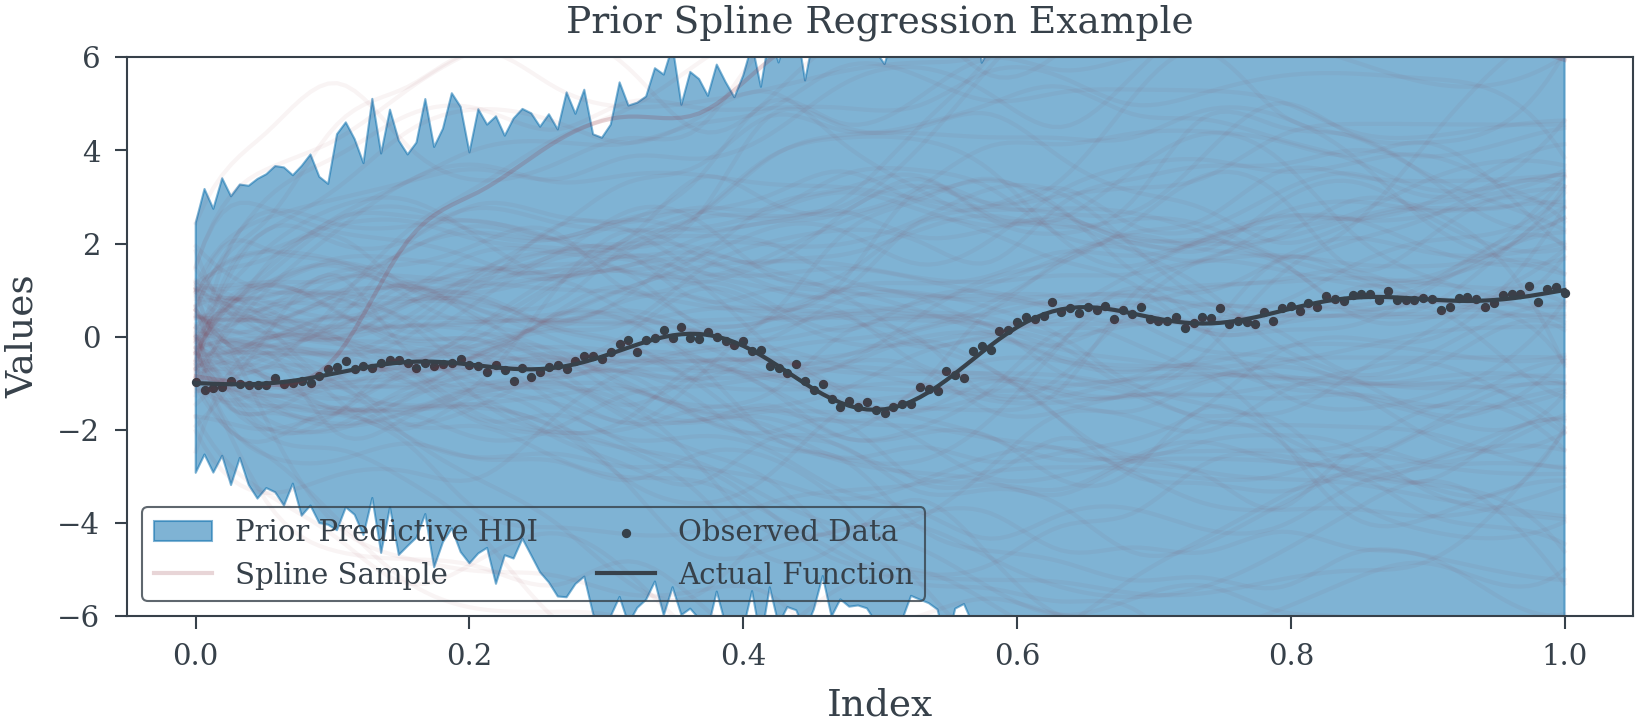

In [ ]:
#| echo: false
#| label: fig-spline-regression-prior
#| fig-cap: Graph of prior samples from the spline regression model.
#| eval: false
hdi = pm.hdi(prior_predictive.prior_predictive.mu)
plt.fill_between(INDEX, hdi.mu.sel(hdi='lower'), hdi.mu.sel(hdi="higher"), color='C3', alpha=.5, label="Prior Predictive HDI")
plt.plot(INDEX, prior_predictive.prior.splines.sel(draw=100, chain=0), color='C0', alpha=.2, label='Spline Sample')
for i in range(100):
    plt.plot(INDEX, prior_predictive.prior.splines.sel(draw=i, chain=0), color='C0', alpha=.05)
plt.scatter(INDEX, y_obs, color='C1', label="Observed Data", s=3)
plt.plot(INDEX, fun, color='C1', label="Actual Function")
plt.title("Prior Spline Regression Example")
plt.ylim((-6, 6))
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend(ncols=2);

In [ ]:
#| hide
#| eval: false
with model:
    trace=pm.sample(target_accept=.95, nuts_sampler='nutpie')

In [ ]:
#| echo: false
#| label: tbl-postrerior-trace
#| tbl-cap: Summary of coefficients for the spline regression model.
#| eval: false
pm.summary(trace, var_names=['betas', 'alpha', 'tau'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.009,0.131,-0.243,0.262,0.003,0.002,1407.0,2094.0,1.0
betas[1],-0.063,0.118,-0.281,0.159,0.003,0.002,2027.0,2518.0,1.0
betas[2],0.378,0.114,0.173,0.598,0.003,0.002,1621.0,2392.0,1.0
betas[3],0.548,0.112,0.324,0.743,0.003,0.002,1845.0,2276.0,1.0
betas[4],0.389,0.109,0.177,0.590,0.003,0.002,1625.0,2538.0,1.0
betas[5],0.197,0.113,-0.034,0.391,0.003,0.002,1607.0,2097.0,1.0
betas[6],0.977,0.111,0.757,1.175,0.003,0.002,1613.0,1949.0,1.0
betas[7],1.206,0.113,1.009,1.435,0.003,0.002,1537.0,2096.0,1.0
betas[8],0.692,0.109,0.469,0.883,0.002,0.002,1924.0,2232.0,1.0
betas[9],-0.551,0.107,-0.756,-0.350,0.003,0.002,1737.0,2105.0,1.0


In [ ]:
#| hide
#| eval: false
with model:
    post_pre = pm.sample_posterior_predictive(trace)

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00  52% 0:00:01 / 0:00:00


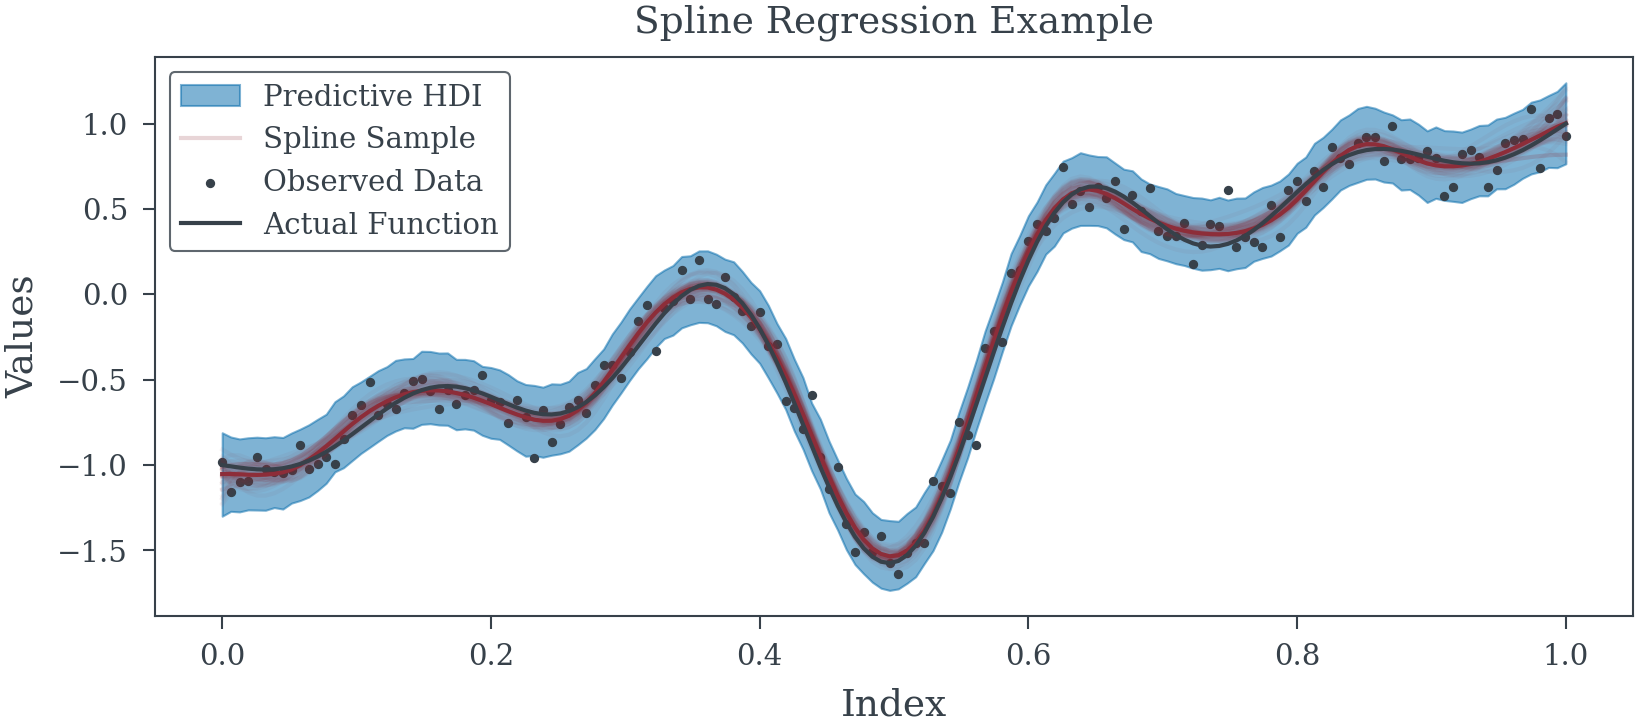

In [ ]:
#| echo: false
#| label: fig-spline-regression-posterior
#| fig-cap: Posterior for horseshoe regularized spline regression.
#| eval: false
hdi = pm.hdi(post_pre.posterior_predictive.mu)
plt.fill_between(INDEX, hdi.mu.sel(hdi='lower'), hdi.mu.sel(hdi="higher"), color='C3', alpha=.5, label="Predictive HDI")
plt.plot(INDEX, trace.posterior.splines.sel(draw=100, chain=0), color='C0', alpha=.2, label='Spline Sample')
for i in range(50):
    plt.plot(INDEX, trace.posterior.splines.sel(draw=i, chain=0), color='C0', alpha=.05)
plt.plot(INDEX, trace.posterior.splines.median(dim=('draw', 'chain')))
plt.scatter(INDEX, y_obs, color='C1', label="Observed Data", s=3)
plt.plot(INDEX, fun, color='C1', label="Actual Function")
plt.title("Spline Regression Example")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend();

:::

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()